# 2. Water Lilies Challenge



In [ ]:
import sys
sys.path.append("/srv/explore-the-collections/code/ivpy/src/")

```{sidebar} Datasets
  * [Art Institute of Chicago](https://www.artic.edu/)
  * [V&A](https://www.vam.ac.uk/)
```

Amongst the [Art Institute of Chicago](https://www.artic.edu/)'s works are paintings by Monet, celebrated in the re-opening exhibition for 2021 [Monet and Chicago](https://www.artic.edu/exhibitions/9036/monet-and-chicago). 

The AIC has also, like the [V&A](https://www.vam.ac.uk/), recently launched a new collections [API](https://api.artic.edu/docs/).

So, with two new collections APIs available, the obvious question is, who has the most Water Lilies in their collection ?

```{note}
In case anybody has accidently come to this page thinking this is a serious art historical data investigation, it is very definitely not, and no conclusions should be drawn about water lilies at the V&A or the Art Institute of Chicago or indeed, anywhere.
```

## Water Lilies in Chicago

First we see how many Water Lilies the AIC have in their collection:

In [13]:
import requests
req = requests.get("https://api.artic.edu/api/v1/artworks/search?q=Water%20Lilies&fields=title,id")
results = req.json()
print(f"The AIC has {results['pagination']['total']} objects mentioning 'Water Lilies'")

The AIC has 2838 objects mentioning 'Water Lilies'


## Water Lilies in London

Next, how many the V&A have in the collection:

In [1]:
import requests
req = requests.get("https://api.vam.ac.uk/v2/objects/search?q=Water%20Lilies")
results = req.json()
print(f"The V&A has {results['info']['record_count']} objects mentioning 'Water Lilies'")

The V&A has 176 objects mentioning 'Water Lilies'


That's a huge victory for the AIC there. Let's see if we can tell when this Water Lily dominance started, by counting per year how many objects mentioning Water Lilies come into each collection.

## Graphing Water Lilies 

The AIC allows us to query using Elasticsearch aggregations, so let's aggregate the objects on the year they came into the AIC collection

In [3]:
import requests
import pandas as pd
import altair as alt

data = {
  "q": "Water Lilies",
  "limit": 0,
  "aggs": {
    "years": {
      "terms": {
        "size": 100,
        "field": "fiscal_year"
      }
    }
  }
}

aic_response = requests.post("https://api.artic.edu/api/v1/artworks/search", json=data)
aic_water_lilies = aic_response.json()["aggregations"]["years"]["buckets"]
aic_water_lilies_df = pd.DataFrame(aic_water_lilies)

bars = alt.Chart(aic_water_lilies_df).mark_bar().encode(x='doc_count:Q',y="key:O")
text = bars.mark_text( align='left', baseline='middle', dx=3 ).encode( text='doc_count:Q')

(bars + text).properties(height=1000, title="Objects mentioning Water Lilies accessioned to the Art Institute of Chicago")

alt.LayerChart(...)

Now for the same for the V&A, using the [clustering](https://developers.vam.ac.uk/guide/v2/data-vis/clustering.html) endpoint:

In [4]:
import requests
import altair as alt
import pandas as pd

req = requests.get('https://api.vam.ac.uk/v2/objects/clusters/accession_year/search?q=Water%20Lilies&cluster_size=100')
vam_water_lilies_df = pd.DataFrame(req.json())

bars = alt.Chart(vam_water_lilies_df).mark_bar().encode(  x='count:Q', y="value:O")
text = bars.mark_text( align='left',baseline='middle',  dx=3 ).encode( text='count:Q')

(bars + text).properties(height=900, title="Objects mentioning Water Lilies accessioned to the V&A")

alt.LayerChart(...)

Well, that seems like a clear victory for the AIC. Let's compare them side-by-side to see when this water lily collecting spree started.

In [6]:
aic_water_lilies_df['institution'] = 'Art Institute of Chicago'
vam_water_lilies_df['institution'] = 'Victoria & Albert Museum'

# Make the columns names consistent

aic_water_lilies_df.rename(columns={'doc_count': 'count', 'key': 'year'}, inplace=True)
vam_water_lilies_df.rename(columns={'value': 'year'}, inplace=True)

# Join into one data-frame
water_lilies_df = aic_water_lilies_df.append(vam_water_lilies_df)

alt.Chart(water_lilies_df).mark_bar().encode(
    y='count:Q',
    x='year:O',
    color='institution:N')

alt.Chart(...)

So, until 1921 the AIC showed no interest in Water Lilies, and the V&A had a small, but consistent interest. But from 1921 (clearly an epic year for water lilies), the AIC seems to have gone crazy for water lilies and shows no signs of stopping, with 1990 being another bumper crop.


## Water Lilies Images

Let's take a look at some of those beautiful water lilies from 1921:

In [88]:
import requests

aic_response = requests.get("https://api.artic.edu/api/v1/artworks/search/?q=Water%20Lilies&query[term][fiscal_year]=1921&fields=title,image_id&limit=27")
aic_waterlilies_1921 = aic_response.json()['data']
aic_waterlilies_1921_df = pd.DataFrame(aic_waterlilies_1921)
aic_waterlilies_1921_df.head()

,_score,image_id,title
0,294.283330,588a5ba9-6cb0-7c99-7024-b8919b0e85ed,Pond with Water Lilies
1,70.699066,d142424d-5232-3aa4-c78a-9faa830472d0,Cattle in Water
2,67.653780,0fb01e26-1dcd-bba2-a146-d0adf183a2b1,The Death of Dido
3,60.903767,ebe8a2da-0661-c8d9-7729-2179fdd3fbc1,Woman Carrying Water Jar
4,55.044228,629f8ab0-613f-e726-8860-fb7bd87b674f,Port of the Alhambra from the Dario


We need to convert the image identifier to a full URL for an image from the IIIF Image API

In [89]:
IIIF_IMAGE_URL = "https://www.artic.edu/iiif/2/%s/full/100,100/0/default.jpg"
aic_waterlilies_1921_df.image_id = [IIIF_IMAGE_URL % item for item in aic_waterlilies_1921_df.image_id]

0     https://www.artic.edu/iiif/2/588a5ba9-6cb0-7c9...
1     https://www.artic.edu/iiif/2/d142424d-5232-3aa...
2     https://www.artic.edu/iiif/2/0fb01e26-1dcd-bba...
3     https://www.artic.edu/iiif/2/ebe8a2da-0661-c8d...
4     https://www.artic.edu/iiif/2/629f8ab0-613f-e72...
5     https://www.artic.edu/iiif/2/13244e9e-a474-623...
6     https://www.artic.edu/iiif/2/749f1093-7713-464...
7     https://www.artic.edu/iiif/2/a191eb49-ffdb-15f...
8     https://www.artic.edu/iiif/2/12a5ffb6-a798-53c...
9     https://www.artic.edu/iiif/2/81e00a42-faa7-90e...
10    https://www.artic.edu/iiif/2/253f6643-e132-49f...
11    https://www.artic.edu/iiif/2/787db7a0-8322-1aa...
12    https://www.artic.edu/iiif/2/62cbb8f1-ad48-1a1...
13    https://www.artic.edu/iiif/2/4b746d60-8a70-bbb...
14    https://www.artic.edu/iiif/2/547738cd-3ce1-677...
15    https://www.artic.edu/iiif/2/5441a861-012e-8b8...
16    https://www.artic.edu/iiif/2/eaf4d362-1f4d-ef8...
17    https://www.artic.edu/iiif/2/b1e660ad-40e6

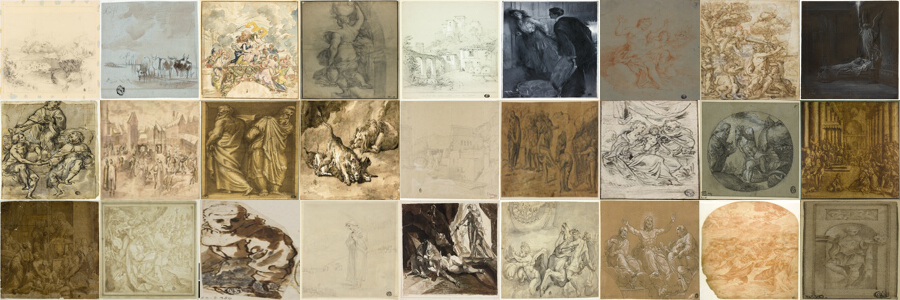

In [90]:
from ivpy import attach,show
attach(aic_waterlilies_1921_df, "image_id")
show()

Well, far be it from us to suggest these objects are not water lilies, but some of them seem very un-flower like. 

A closer look at the results on the AIC collections page, suggests that the search we have been carrying out with the two terms "Water" and "Lilies" is returning results with either or both of the terms, so we are seeing lots of results that just have the word Water, not Lilies. The V&A search forces records to have both words in results. Both results are perfectly valid, and relate to a perennial discussion about whether broader or narrower results are better for users.

But, we need to know, who has the most Water Lilies?

We can make sure we are seeing exact matches for both APIs by using phrase searching (surrounding the terms we want to search for with quotation marks, so "Water Lilies")

Let's repeat the above and show the images again, could the V&A take back the water lilies lead?

In [92]:
import requests

aic_response = requests.get('https://api.artic.edu/api/v1/artworks/search/?q="Water Lilies"&fields=title,image_id&limit=27')
aic_waterlilies_all = aic_response.json()['data']
aic_waterlilies_all_df = pd.DataFrame(aic_waterlilies_all)
aic_waterlilies_all_df.head()

,_score,image_id,title
0,5851.9290,3c27b499-af56-f0d5-93b5-a7f2f1ad5813,Water Lilies
1,4918.5000,8534685d-1102-e1e3-e194-94f6e925e8b0,Water Lily Pond
2,4397.6920,7a23ad22-2044-6d7d-6315-9b101dadc559,Water Lily Pond
3,3458.6910,be652828-cb7d-f563-ec91-576b7b17d477,Water-Lily Vessel
4,2395.0308,76c4cff6-9126-bea6-dd6f-b2b073da5ef5,Water Lilies


In [93]:
IIIF_IMAGE_URL = "https://www.artic.edu/iiif/2/%s/full/100,100/0/default.jpg"
aic_waterlilies_all_df.image_id = [IIIF_IMAGE_URL % item for item in aic_waterlilies_all_df.image_id]

0     https://www.artic.edu/iiif/2/3c27b499-af56-f0d...
1     https://www.artic.edu/iiif/2/8534685d-1102-e1e...
2     https://www.artic.edu/iiif/2/7a23ad22-2044-6d7...
3     https://www.artic.edu/iiif/2/be652828-cb7d-f56...
4     https://www.artic.edu/iiif/2/76c4cff6-9126-bea...
5     https://www.artic.edu/iiif/2/2f5ce2ec-79d8-d32...
6     https://www.artic.edu/iiif/2/a307c274-52c7-001...
7     https://www.artic.edu/iiif/2/906098e9-8607-048...
8     https://www.artic.edu/iiif/2/97320715-812d-269...
9     https://www.artic.edu/iiif/2/e010d3fa-e328-9c3...
10    https://www.artic.edu/iiif/2/26133065-db5d-225...
11    https://www.artic.edu/iiif/2/82cca306-b54b-6c6...
12    https://www.artic.edu/iiif/2/588a5ba9-6cb0-7c9...
Name: image_id, dtype: object

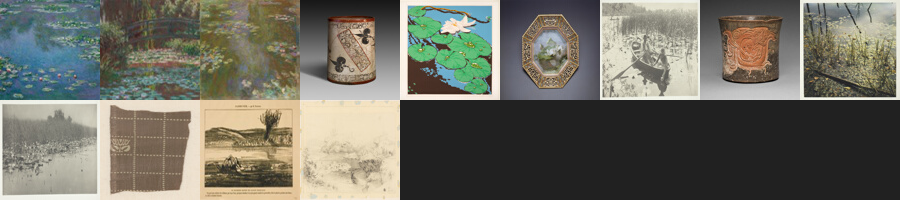

In [95]:
attach(aic_waterlilies_all_df, "image_id")
show()

That looks much more flower like! And now only 13 results. Let's try the same for the V&A

In [98]:
import requests

vam_response = pd.read_csv('https://api.vam.ac.uk/v2/objects/search?q="Water%20Lilies"&images_exist=1&response_format=csv&page_size=50')
vam_waterlilies_all_df = pd.DataFrame(vam_response)
vam_waterlilies_all_df.head()

,accessionNumber,systemNumber,objectType,_primaryTitle,_primaryPlace,_primaryMaker__name,_primaryMaker__association,_primaryDate,_primaryImageId,_sampleMaterial,_sampleTechnique,_sampleStyle,_currentLocation__displayName,_objectContentWarning,_imageContentWarning
0,E.4215-1915,O708198,Engraving,A Water Lily,Britain,Walter Crane,artist,1888,2016JF9574,printing ink,process engraving,NaN,"Prints & Drawings Study Room, level C",False,False
1,MISC.2:4-1934,O97898,Table,Water Lily,England,"Grant, Duncan",painter,1913,2008BT7494,pine,painting,20th century,In store,False,False
2,T.412-1977,O269011,Furnishing fabric,Water Lily,England,Alister Maynard,designer,1960s,2017KM6455,NaN,NaN,NaN,In store,False,False
3,CIRC.5-1972,O268751,Furnishing fabric,Water Lily,Great Britain,Grace Sullivan,designer,1972,2011EY3610,NaN,NaN,NaN,In store,False,False
4,E.2242-2016,O1373041,Print,The Water Lily,England,"Lucas, David",engraver,1830,2016JP8759,paper,Mezzotint,NaN,"Prints & Drawings Study Room, level E",False,False


In [99]:
IIIF_IMAGE_URL = "https://framemark.vam.ac.uk/collections/%s/full/!100,100/0/default.jpg"
vam_waterlilies_all_df._primaryImageId = [IIIF_IMAGE_URL % item for item in vam_waterlilies_all_df._primaryImageId]

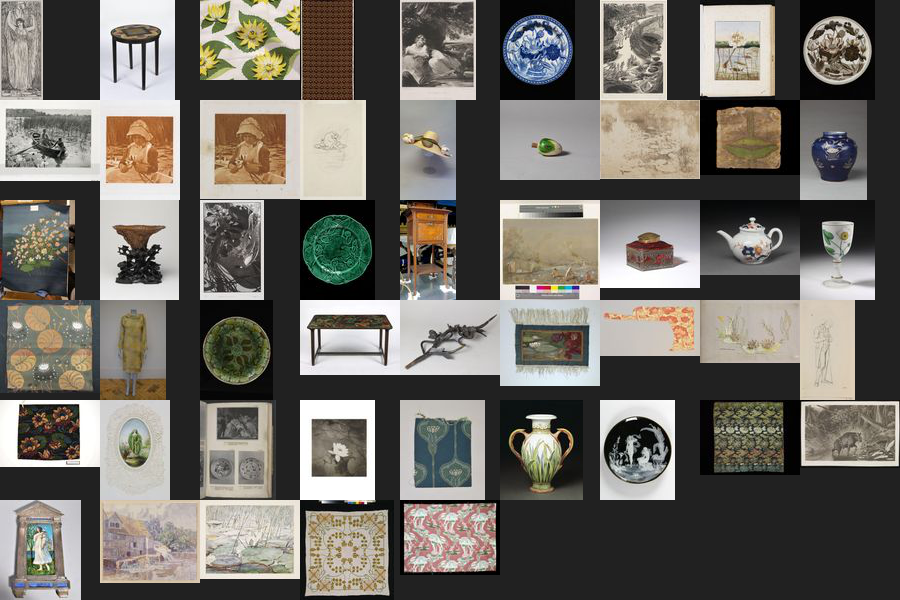

In [100]:
attach(vam_waterlilies_all_df, "_primaryImageId")
show()

## Verdict

Well, that seems conclusive, look at all those water lilies. Admitedly, not all of them are *quite* in the style of Monet. But still, there are water lilies on plates, water lilies on wall paper, water lilies of some sort everywhere. On that basis, we completely un-biasedly declare the V&A the winner of the Water Lily challenge.

```{note}
Readers of the V&A and AIC API docs will be aware that a serious attempt to answer this question would require searching in each collection for all the variations of the way Water Lilies could be entered (Water-Lilies, Water Lilies, Water Lily, etc), and that some objects may depict water lilies but may not yet be catalogued as such.
```